In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tifffile import imread



--- 

Quick overview: Load same crop for IHC and SCRINSHOT

In [51]:
bp = "/Users/louis.kuemmerle/Promotion/projects/G1/code/SCRINSHOT/data/230526_FOS_Staining/"
basal_mask = imread(bp+'IHC/Mask-nuclei-basal-only.tif')
FOS_IHC = imread(bp+'IHC/IHC-analysis_FOS_ORG.tif')
dapi_IHC = imread(bp+'IHC/IHC-analysis_DAPI_ORG.tif')
df_FOS = pd.read_csv(bp+'IHC/FOS-values-withXY.csv')
FOS_scrins = imread(bp+'adjacent_SCINSHOT_crop/588-LNG2_Hyb1_stress-SCRINSHOT-FOS-Create_Image_Subset-02_FOS_ORG.tif')
dapi_scrins = imread(bp+'adjacent_SCINSHOT_crop/588-LNG2_Hyb1_stress-SCRINSHOT-FOS-Create_Image_Subset-02_DAPI_ORG.tif')

In [29]:
print(basal_mask.shape)
print(FOS_IHC.shape)
print(FOS_scrins.shape)


(14896, 5792)
(14896, 5792)
(14896, 5792)


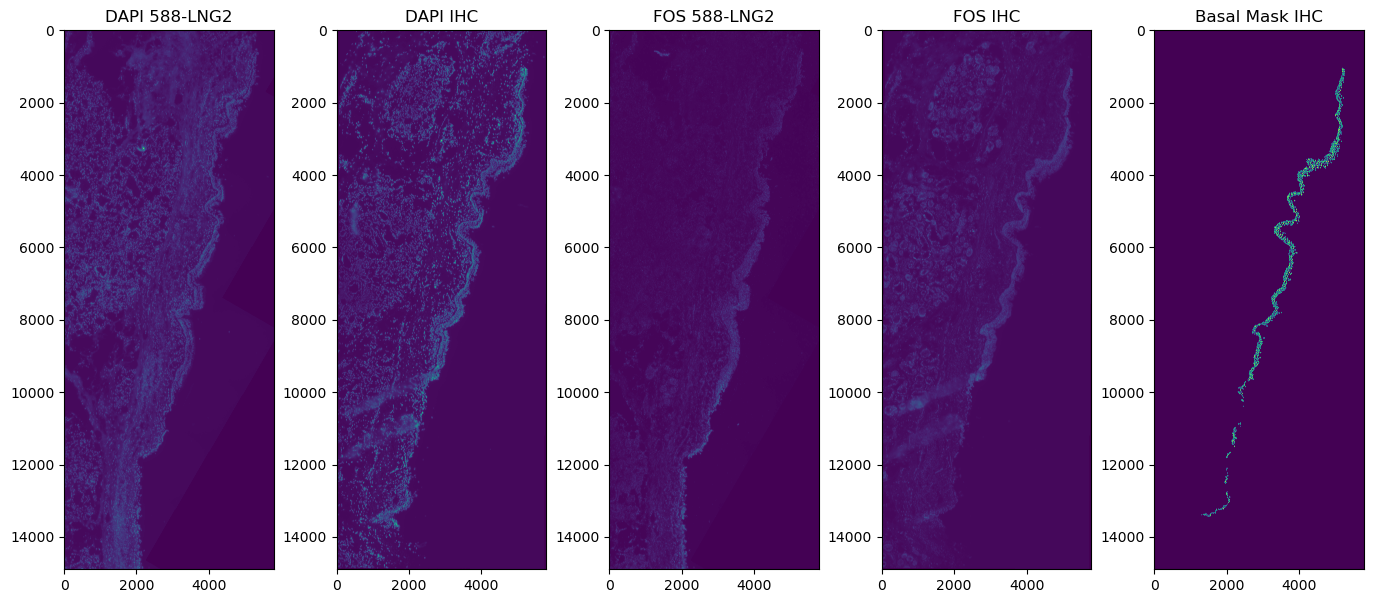

In [31]:
fig, axs = plt.subplots(1, 5, figsize=(17, 7))
axs[0].imshow(dapi_scrins)
axs[0].set_title("DAPI 588-LNG2")
axs[1].imshow(dapi_IHC)
axs[1].set_title("DAPI IHC")
axs[2].imshow(FOS_scrins)
axs[2].set_title("FOS 588-LNG2")
axs[3].imshow(FOS_IHC)
axs[3].set_title("FOS IHC")
axs[4].imshow(basal_mask)
axs[4].set_title("Basal Mask IHC")
plt.show()


End of quick overview

---

Quantification plan:
- Based on dapi images annotate the paths in the epithelia for the IHC slice and the SCRINSHOT slice
- At the same time annotate landmarks along the epithelia pathes for mapping the epithelium between the two slices
- transform each of the paths into a profile (i.e. a set of points)
- measure the fluorescence intensity of the respective fos fluorescence image along the profile for a given width
- plot the fluorescence intensity image masked such that only the intensity along the profile for the given width is visible
- try a few different width values and see which one captures best the epithelium, also plot the fluorescence intensity along the profile points (`plt.plot(fos_intensities)`, at this point don't care about the distances between the points, it's just for getting a check besdies the masked imshow plot)
- find those points in the profiles that are closest to the landmarks, and define those points as the landmarks in the profiles
- now measure the distance along the path profile from each landmark to the subsequent landmark (i.e. over all points of profile between the two landmarks)
- We take the profile points with the maximum number of points per distance interval as a reference to interpolate the other profile points to the same number of points per distance interval. This we do for the profile path of the slice that has the mentioned profile points with the maximum number of points per distance interval. 
- We then interpolate the profile points of the other slice to the same number of points per interval between landmarks as we have in the other slide. This way we can compare the fluorescence intensity along the profile of the two slices.
- We then want to plot a final figures with 6 axes (2 rows, 3 columns). Each row for one slice. The first column shows the dapi image with colored landmark dots (i.e. same color for corresponding landmarks between the two slices). The 2nd column is the FOS signal shown with two colormaps: one colormap for the intensities within the path along the epithelium for the given width (according our quantification along the path), and the second for all intensities outside the epithelium path. The last column just shows the FOS signal (y-axis) along the path (i.e. our interpolated intensities matched between the two slices). In that last plot add colored vertical lines for the landmarks.

given variables:
- 'dapi_ihc' -> dapi image of IHC slice, np.array of shape (y,x)
- 'dapi_scrins' -> dapi image of SCRINSHOT slice, np.array of shape (y,x)
- 'fos_ihc' -> fos image of IHC slice, np.array of shape (y,x)
- 'fos_scrins' -> fos image of SCRINSHOT slice, np.array of shape (y,x)

variables and parameters to manually generate/set:
- path_ihc -> path of epithelium in IHC slice, list of tuples [(x1,y1), (x2,y2), ...]
- path_scrins -> path of epithelium in SCRINSHOT slice, list of tuples [(x1,y1), (x2,y2), ...]
- inital_landmarks_ihc -> landmarks along the path of the IHC slice, list of tuples [(x1,y1), (x2,y2), ...]
- inital_landmarks_scrins -> landmarks along the path of the SCRINSHOT slice, list of tuples [(x1,y1), (x2,y2), ...]
- width -> width of the path, int

variables to be generated (not all included):
- landmarks_ihc -> landmarks in the path of the IHC slice, list of tuples [(x1,y1), (x2,y2), ...]
- landmarks_scrins -> landmarks in the path of the SCRINSHOT slice, list of tuples [(x1,y1), (x2,y2), ...]
- profile_ihc -> profile of the IHC slice, list of tuples [(x1,y1), (x2,y2), ...]
- profile_scrins -> profile of the SCRINSHOT slice, list of tuples [(x1,y1), (x2,y2), ...]
- distance_between_points -> float value of the distance between two points in the profile (retrieved from the profile between the two landmarks with the maximum number of points per distance interval)
- profile_ihc_interpolated -> profile of the IHC slice interpolated to the same number of points per distance interval as the SCRINSHOT slice, list of tuples [(x1,y1), (x2,y2), ...]
- profile_scrins_interpolated -> profile of the SCRINSHOT slice interpolated to the same number of points per distance interval as the IHC slice, list of tuples [(x1,y1), (x2,y2), ...]




# Quantification of Fluorescence Signal in Lung Tissue Slides

This script is designed for quantifying and comparing the fluorescence signal along the epithelial layer in two adjacent lung tissue slides.

In [2]:
from pathlib import Path
from tifffile import imread
from datetime import datetime
import numpy as np
import pandas as pd
import napari
import matplotlib.pyplot as plt
from skimage.measure import profile_line

# 0. Load data

In [3]:
bp = "/Users/louis.kuemmerle/Promotion/projects/G1/code/SCRINSHOT/data/230526_FOS_Staining/"

fos_ihc = imread(bp+'IHC/IHC-analysis_FOS_ORG.tif')
dapi_ihc = imread(bp+'IHC/IHC-analysis_DAPI_ORG.tif')
fos_scrins = imread(bp+'adjacent_SCINSHOT_crop/588-LNG2_Hyb1_stress-SCRINSHOT-FOS-Create_Image_Subset-02_FOS_ORG.tif')
dapi_scrins = imread(bp+'adjacent_SCINSHOT_crop/588-LNG2_Hyb1_stress-SCRINSHOT-FOS-Create_Image_Subset-02_DAPI_ORG.tif')

## 1. Annotation
- **Objective**: Manually annotate paths along the epithelial layer and landmarks using Napari.
- **Input**: DAPI images of IHC and SCRINSHOT slices.
- **Output**: Paths and landmarks annotated.

In [4]:
def save_to_csv(path_ihc, path_scrins, landmarks_ihc, landmarks_scrins):
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    Path("results/fos_annotations").mkdir(parents=True, exist_ok=True)
    base_filename = f"results/fos_annotations/{timestamp}"

    # Save paths
    pd.DataFrame(path_ihc).to_csv(f'{base_filename}_path_ihc.csv', index=False)
    pd.DataFrame(path_scrins).to_csv(
        f'{base_filename}_path_scrins.csv', index=False)

    # Save landmarks
    pd.DataFrame(landmarks_ihc).to_csv(
        f'{base_filename}_landmarks_ihc.csv', index=False)
    pd.DataFrame(landmarks_scrins).to_csv(
        f'{base_filename}_landmarks_scrins.csv', index=False)

    print(f"Annotations saved with timestamp: {timestamp}")


def load_from_csv(timestamp):
    base_filename = f"results/fos_annotations/{timestamp}"

    # Load paths
    path_ihc = pd.read_csv(f'{base_filename}_path_ihc.csv').values
    path_scrins = pd.read_csv(f'{base_filename}_path_scrins.csv').values

    # Load landmarks
    landmarks_ihc = pd.read_csv(f'{base_filename}_landmarks_ihc.csv').values
    landmarks_scrins = pd.read_csv(
        f'{base_filename}_landmarks_scrins.csv').values

    return path_ihc, path_scrins, landmarks_ihc, landmarks_scrins


In [4]:
# ONLY RUN THIS CELL IF YOU WANT TO REDO THE ANNOTATIONS

# Initialize the viewer with the DAPI images
viewer = napari.Viewer()
viewer.add_image(dapi_ihc, name="DAPI IHC")#, colormap='cyan')
viewer.add_image(dapi_scrins, name="DAPI SCRINSHOT")#, colormap='magenta')

# Add layers for path and landmark annotations
path_layer_ihc = viewer.add_shapes(shape_type='path', name="Path IHC", edge_color='red', edge_width=20)
path_layer_scrins = viewer.add_shapes(shape_type='path', name="Path SCRINSHOT", edge_color='red', edge_width=20)
landmarks_layer_ihc = viewer.add_points(name="Landmarks IHC", face_color='yellow', size=100)
landmarks_layer_scrins = viewer.add_points(name="Landmarks SCRINSHOT", face_color='yellow', size=100)

In [15]:
# Get the annotated paths and landmarks and save them
path_ihc = path_layer_ihc.data[0]
path_scrins = path_layer_scrins.data[0]
initial_landmarks_ihc = landmarks_layer_ihc.data
initial_landmarks_scrins = landmarks_layer_scrins.data

# Save annotations
save_to_csv(path_ihc, path_scrins, initial_landmarks_ihc, initial_landmarks_scrins)

Annotations saved with timestamp: 20230610-141325


Not sure why but I don't manage to fully close napari, you might want to restart the script and continue from here

In [5]:
# Load the saved data, use the timestamp printed during saving
timestamp = "20230610-141325" # "YOUR_TIMESTAMP_HERE"
path_ihc, path_scrins, initial_landmarks_ihc, initial_landmarks_scrins = load_from_csv(timestamp)

## 2. Find landmarks in paths
- **Objective**: Find landmarks in the paths based on the shortest distance between path points and the annotated landmarks. First the number of points along the path is increased to 1 point per 5 pixel distance.
- **Output**: Landmarks within the paths for IHC and SCRINSHOT slices.

In [6]:
def increase_n_points_along_path(path, n_per_pixel=0.2):
    """Add points between the points of a path to increase the number of points along the path
    """
    new_path = []
    for i in range(len(path) - 1):
        # Calculate the distance between the two points
        dist = np.linalg.norm(path[i + 1] - path[i])

        # Calculate the number of points to add
        n_points_to_add = int(dist * n_per_pixel)
        if n_points_to_add > 0:
            x_dist_per_point = (path[i + 1][1] - path[i][1]) / n_points_to_add
            y_dist_per_point = (path[i + 1][0] - path[i][0]) / n_points_to_add
        n_points_to_add -= 1 # We already have the last point

        # Add points to the path
        new_path.append(path[i])
        if n_points_to_add > 0:
            for j in range(n_points_to_add):
                new_path.append([path[i][0] + (j+1) * y_dist_per_point, path[i][1] + (j+1) * x_dist_per_point])
    new_path.append(path[-1])
    return np.array(new_path)
        

def find_closest_point(point, path):
    """Find the closest point in a list of points to a given point"""
    return np.array(path[np.argmin(np.linalg.norm(path - point, axis=1))])

def find_landmarks_in_path(path, landmarks):
    """Find the landmarks that are closest to the points in a given path"""
    return np.array([find_closest_point(point, path) for point in landmarks])

def trim_path_to_landmarks(path, landmarks):
    """Remove points from path that come before the first landmark and after the last landmark"""
    landmarks_in_path = find_landmarks_in_path(path, landmarks)
    first_landmark = landmarks_in_path[0]
    last_landmark = landmarks_in_path[-1]
    first_landmark_index = np.where((path == first_landmark).all(axis=1))[0][0]
    last_landmark_index = np.where((path == last_landmark).all(axis=1))[0][0]
    return path[first_landmark_index:last_landmark_index+1]
    

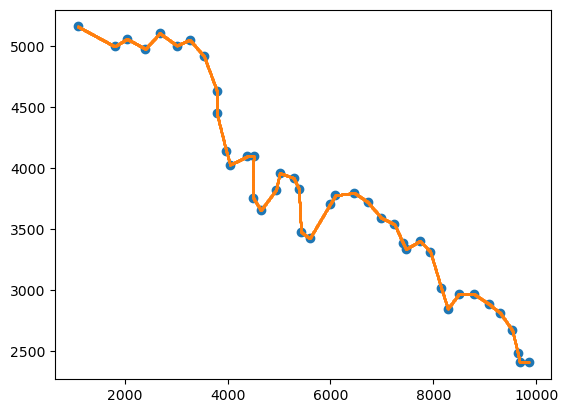

In [7]:
plt.scatter(path_ihc[:,0], path_ihc[:,1])
tmp = increase_n_points_along_path(path_ihc, 0.2)
plt.scatter(tmp[:,0], tmp[:,1], s=1)

In [8]:
# Increase the number of points along the paths
path_ihc_hres = increase_n_points_along_path(path_ihc, 0.2)
path_scrins_hres = increase_n_points_along_path(path_scrins, 0.2)

In [9]:
# Find the exact positions of the landmarks in the paths
landmarks_ihc = find_landmarks_in_path(path_ihc_hres, initial_landmarks_ihc)
landmarks_scrins = find_landmarks_in_path(path_scrins_hres, initial_landmarks_scrins)

In [10]:
# Cut away the parts of the paths that are before the first landmark and after the last landmark
path_ihc_hres = trim_path_to_landmarks(path_ihc_hres, landmarks_ihc)
path_scrins_hres = trim_path_to_landmarks(path_scrins_hres, landmarks_scrins)
path_ihc[0,:] = path_ihc_hres[0,:]
path_ihc[-1,:] = path_ihc_hres[-1,:]
path_scrins[0,:] = path_scrins_hres[0,:]
path_scrins[-1,:] = path_scrins_hres[-1,:]

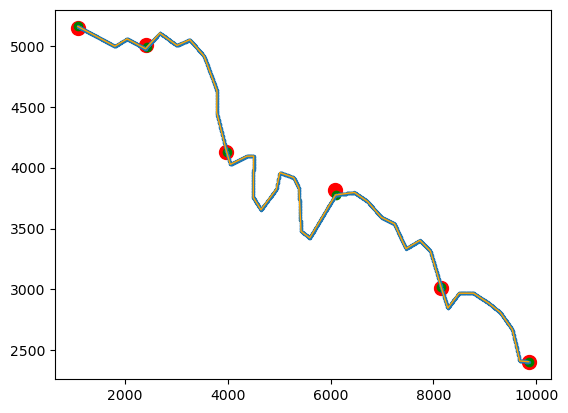

In [11]:
plt.scatter(initial_landmarks_ihc[:,0], initial_landmarks_ihc[:,1], color='red',s=100)
plt.scatter(landmarks_ihc[:,0], landmarks_ihc[:,1], color='green')
plt.scatter(path_ihc_hres[:,0], path_ihc_hres[:,1], s=2)
plt.plot(path_ihc[:,0], path_ihc[:,1], color='orange', linewidth=1)
plt.show()

In [12]:
# Filter out duplicates in the paths (not exactly sure where a duplicate can come from, but paths look rly fine otherwise...)
_, idx = np.unique(path_ihc, axis=0, return_index=True)
path_ihc = path_ihc[np.sort(idx)]

_, idx = np.unique(path_scrins, axis=0, return_index=True)
path_scrins = path_scrins[np.sort(idx)]

# doesn't retain the order of the points
# path_ihc = np.unique(path_ihc, axis=0)
# path_scrins = np.unique(path_scrins, axis=0)


# 3. Measure Fluorescence Intensity Along Profiles
- **Objective**: Measure the fluorescence intensity along the profiles using the respective FOS images and define the width around the path that is quantified.
- **Action**: Based on plots for different widths specify the final width along which the fluorescence signal will be quantified.
- **Output**: Fluorescence intensities along the profiles.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import profile_line


def get_masked_profiled_area(image, path, width):

    # Create a mask of the same shape as the image with all values set to NaN
    masked_img = np.full_like(image, np.nan)

    # Iterate through segments in the path
    for i in range(len(path) - 1):
        # Get the start and end points of the current segment
        start, end = path[i], path[i + 1]

        # Get the profile line
        profile = profile_line(
            image, start, end, linewidth=width, mode='constant', cval=np.nan)

        # Compute the number of points in the profile
        num_points = profile.shape[0]

        # Compute the line vector
        line_vector = np.array(end) - np.array(start)

        # Compute the normal vector to the line
        normal_vector = np.array([-line_vector[1], line_vector[0]])
        normal_vector = normal_vector / np.linalg.norm(normal_vector)

        if num_points <= 1:
            continue

        # Iterate through points in the profile and fill in the mask
        for j in range(num_points):
            # Calculate position along the line
            position = start + j / (num_points - 1) * line_vector

            # Extend the width on both sides
            for w in np.linspace(-width/2, width/2, int(width)):
                # Calculate position perpendicular to the line
                pos_perpendicular = position + w * normal_vector

                # Convert position to integer coordinates
                x, y = map(int, np.round(pos_perpendicular))

                # Bounds check and mask
                if 0 <= x < image.shape[0] and 0 <= y < image.shape[1]:
                    masked_img[x, y] = image[x, y]

    return masked_img


def get_profile(image, path, width=5):
    profiles = []

    for i in range(len(path)-1):
        start, end = path[i], path[i+1]
        profile = profile_line(image, start, end, linewidth=width)
        profiles.append(profile)

    return profiles


def plot_profiled_area(image, path, width):
    """Plot the profiled area on top of the image"""
    
    # Get the profiled area mask
    masked_img = get_masked_profiled_area(image, path, width)

    # Get the profile intensities
    intensities = np.concatenate(get_profile(image, path, width))

    # Plot the results
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))

    ax[0].imshow(image, cmap='viridis')
    ax[0].plot(path[:, 1], path[:, 0], color='red', linewidth=1)
    ax[0].set_title('Original Image')

    ax[1].imshow(masked_img, cmap='viridis')
    ax[1].set_title('Profiled Area')
    
    ax[2].plot(intensities)
    ax[2].set_title('Profile Intensities')

    plt.show()


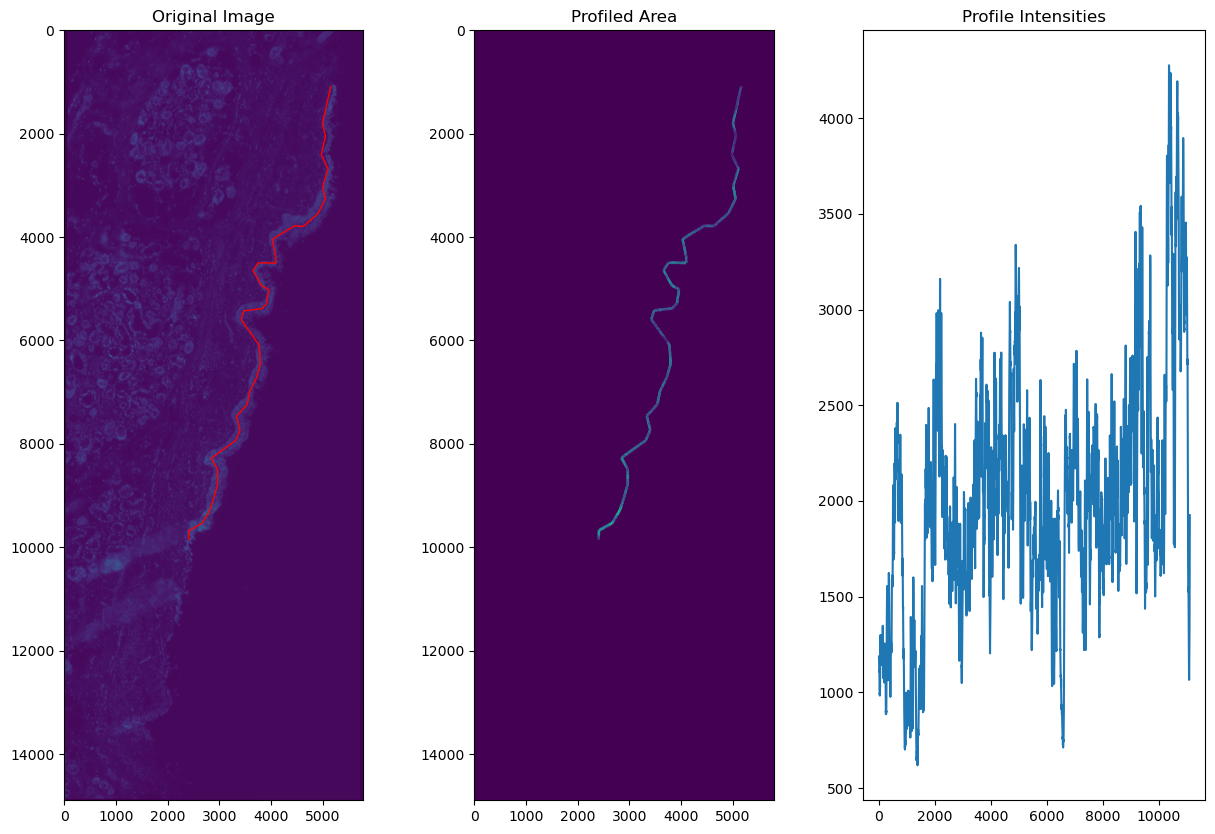

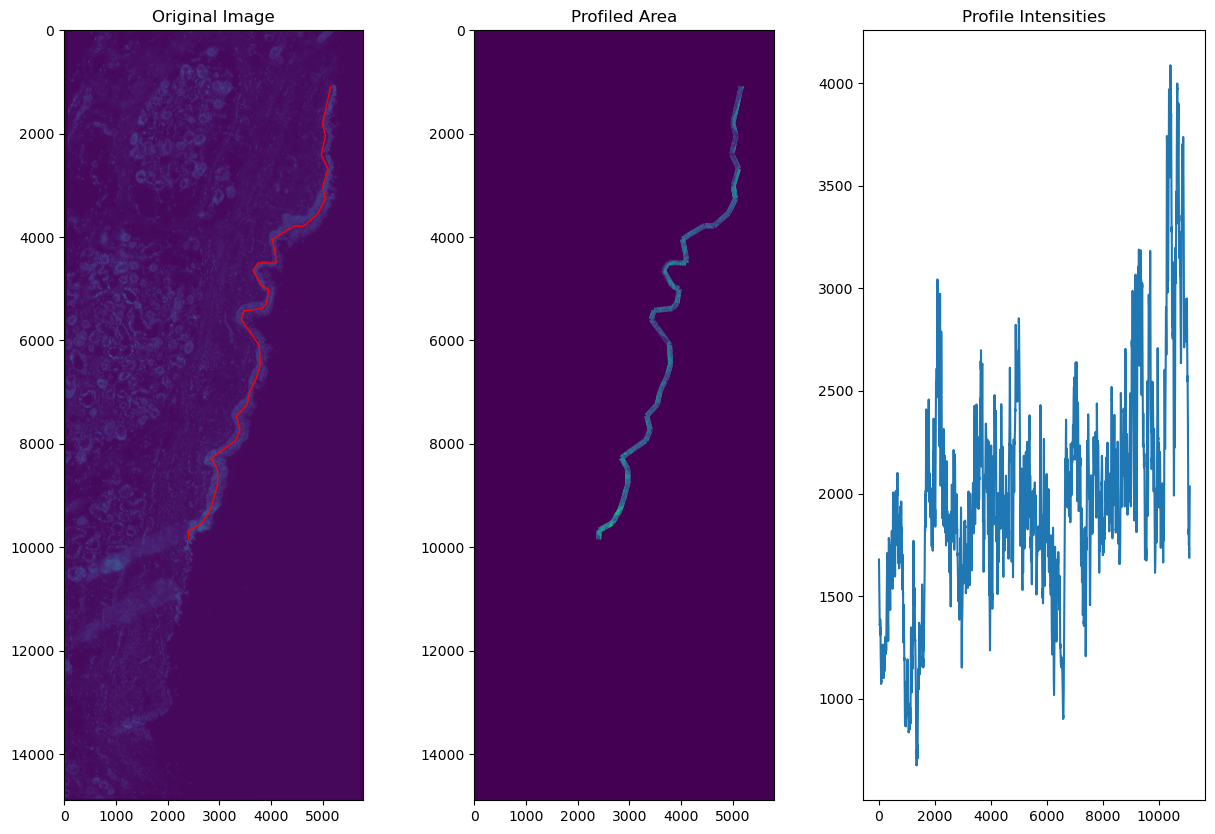

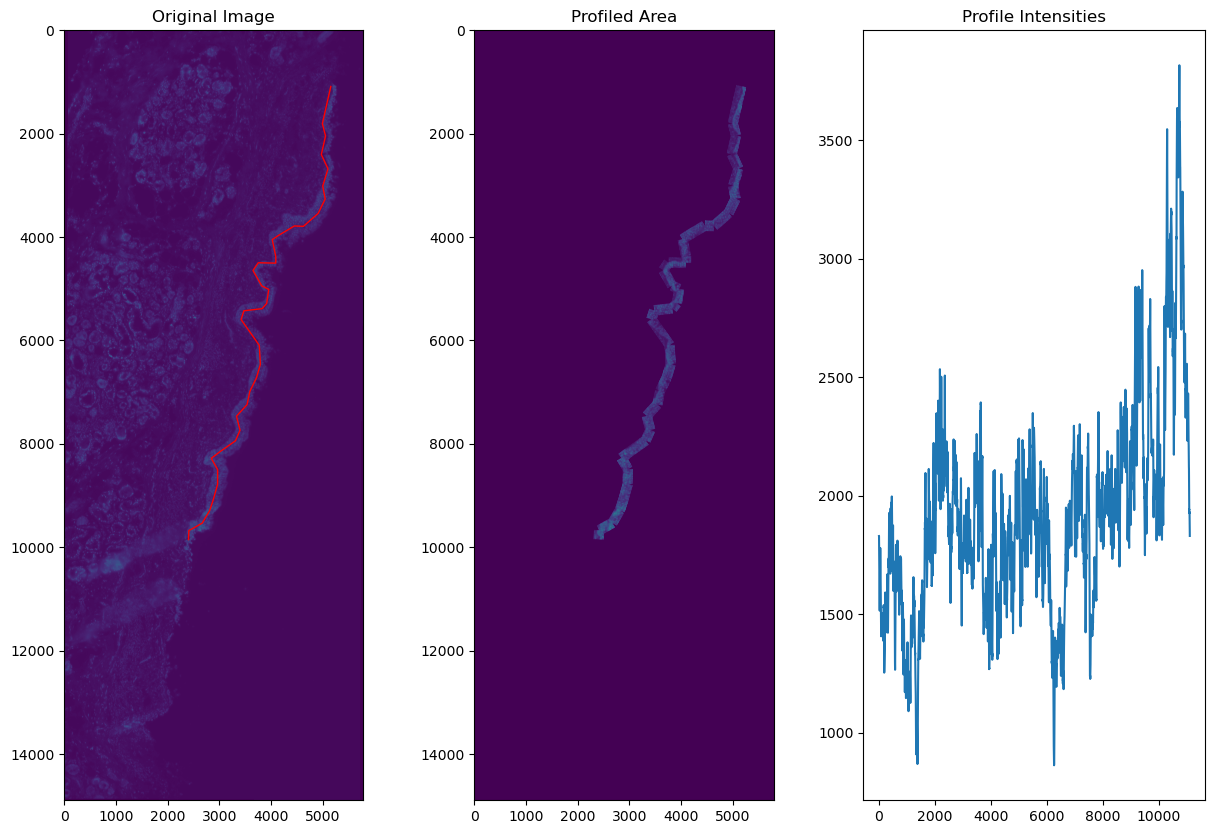

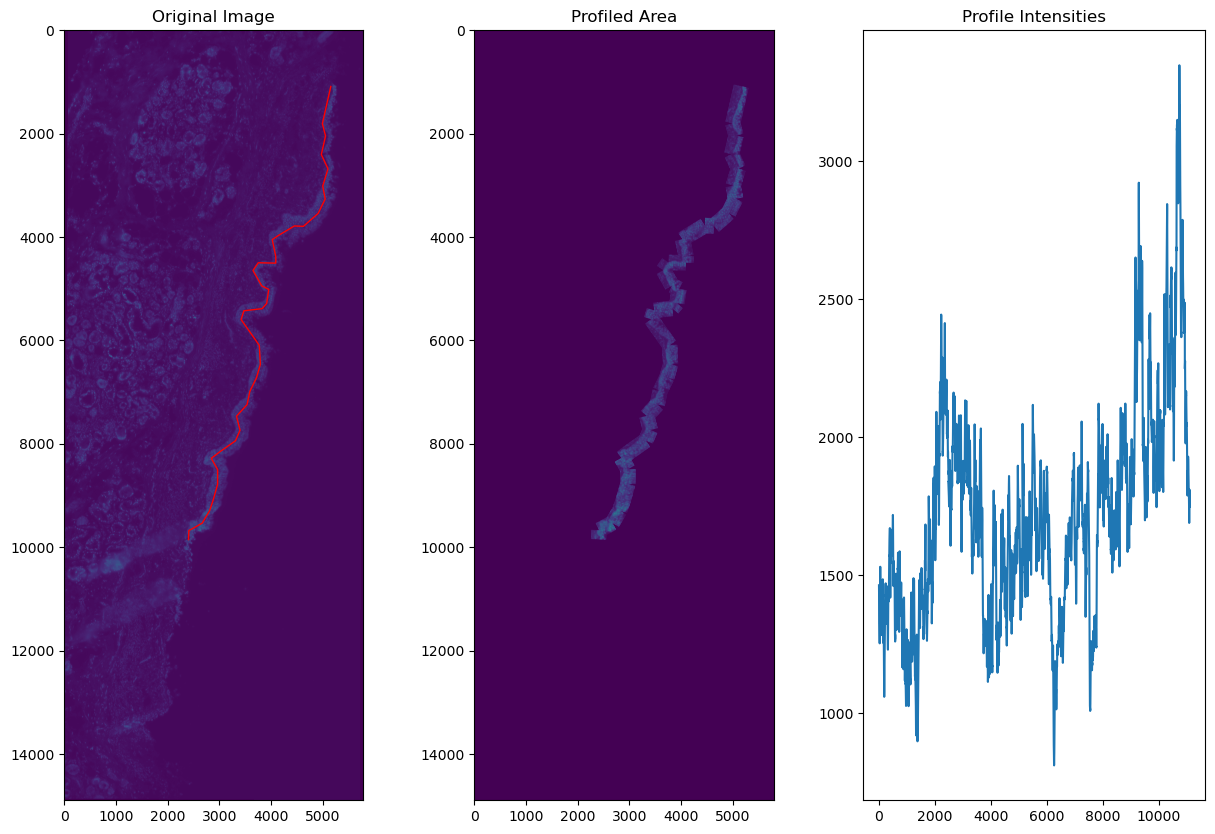

In [26]:
for width in [51, 101, 201, 301]:
    plot_profiled_area(fos_ihc, path_ihc, width=width)

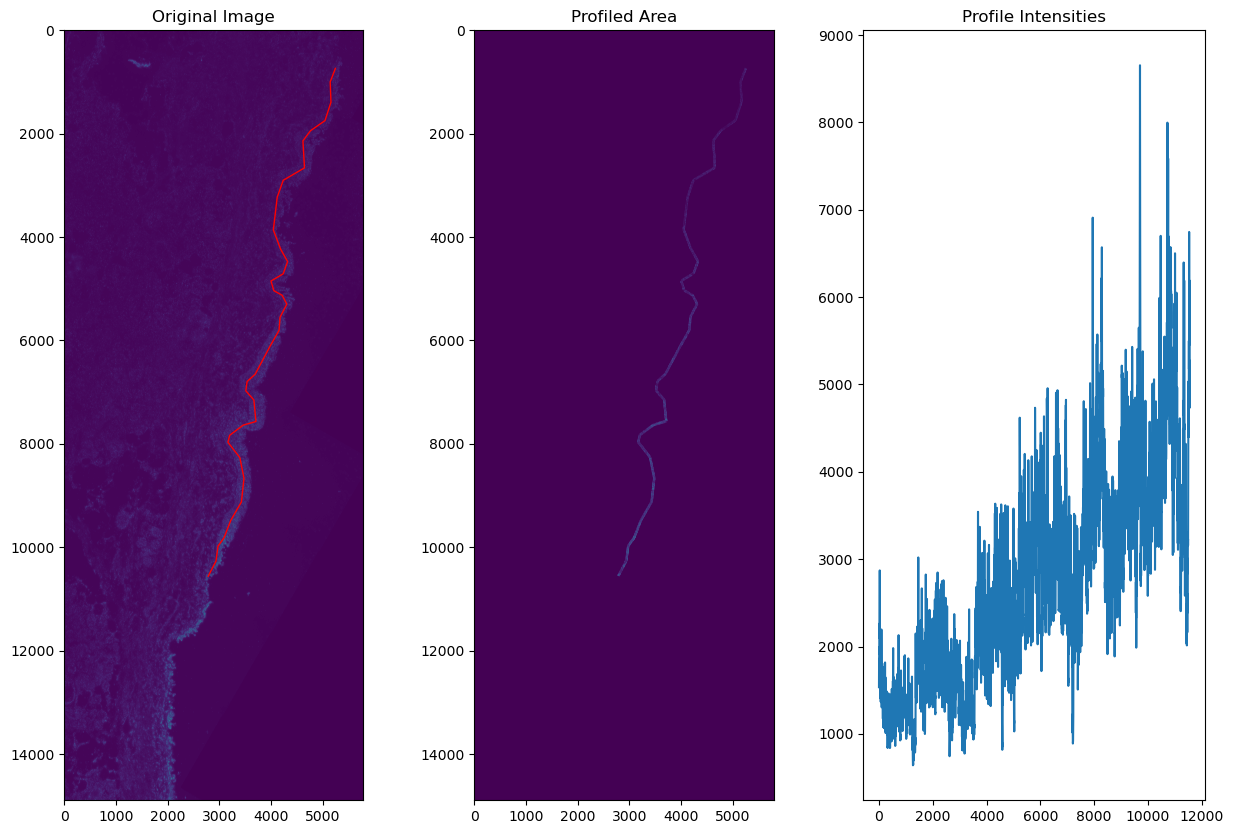

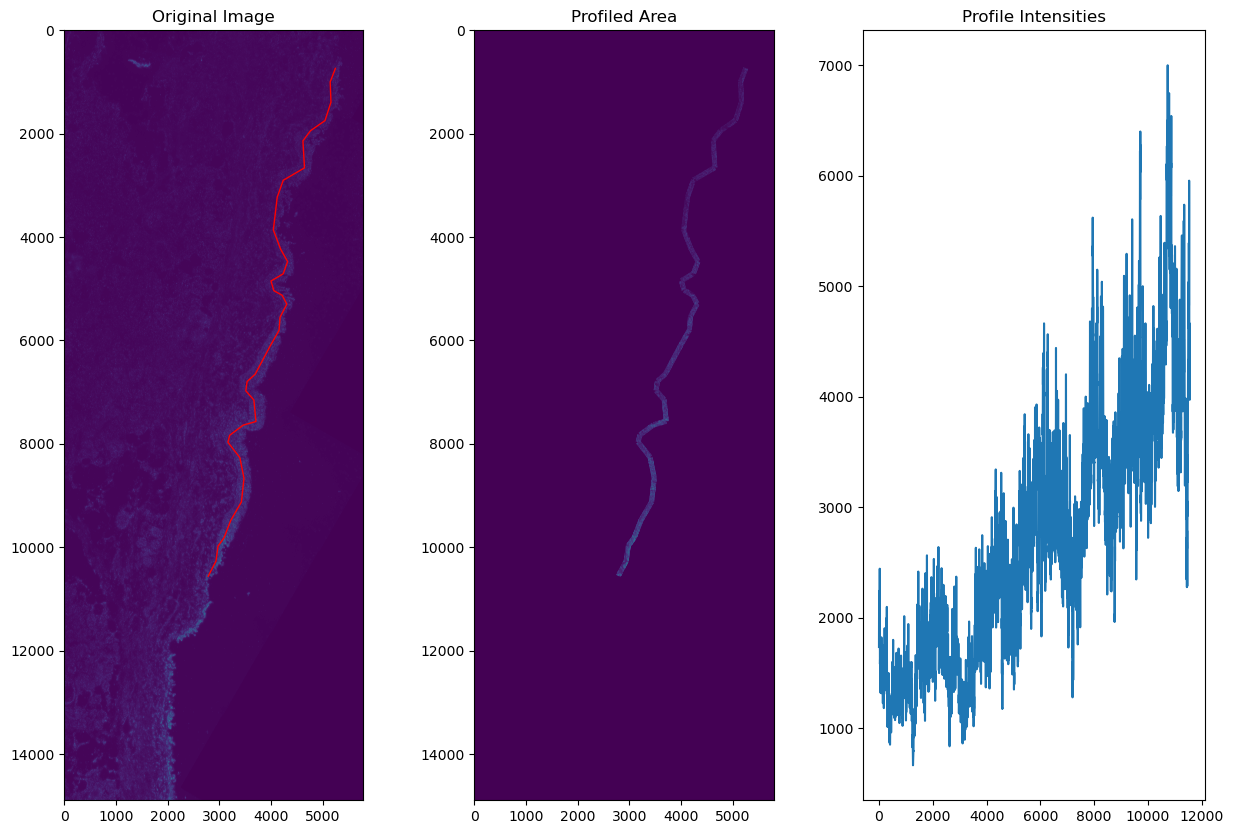

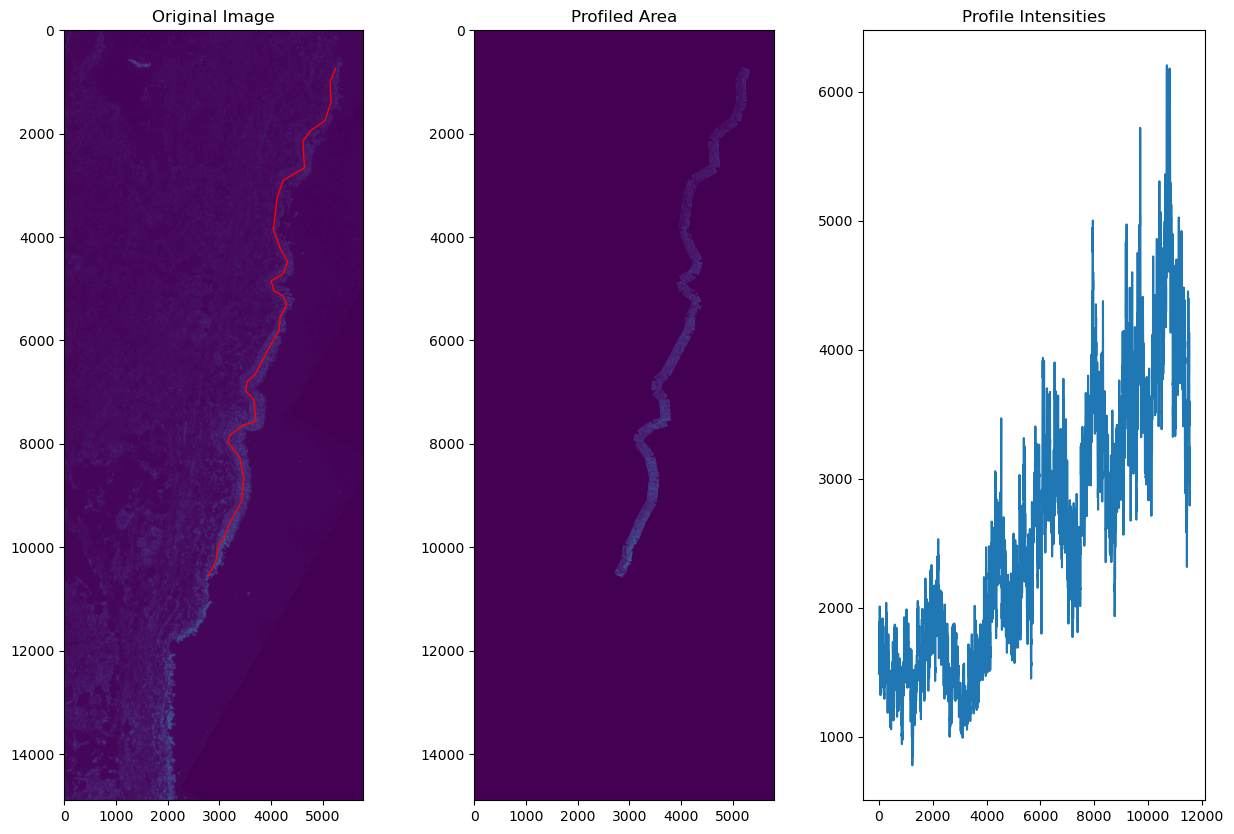

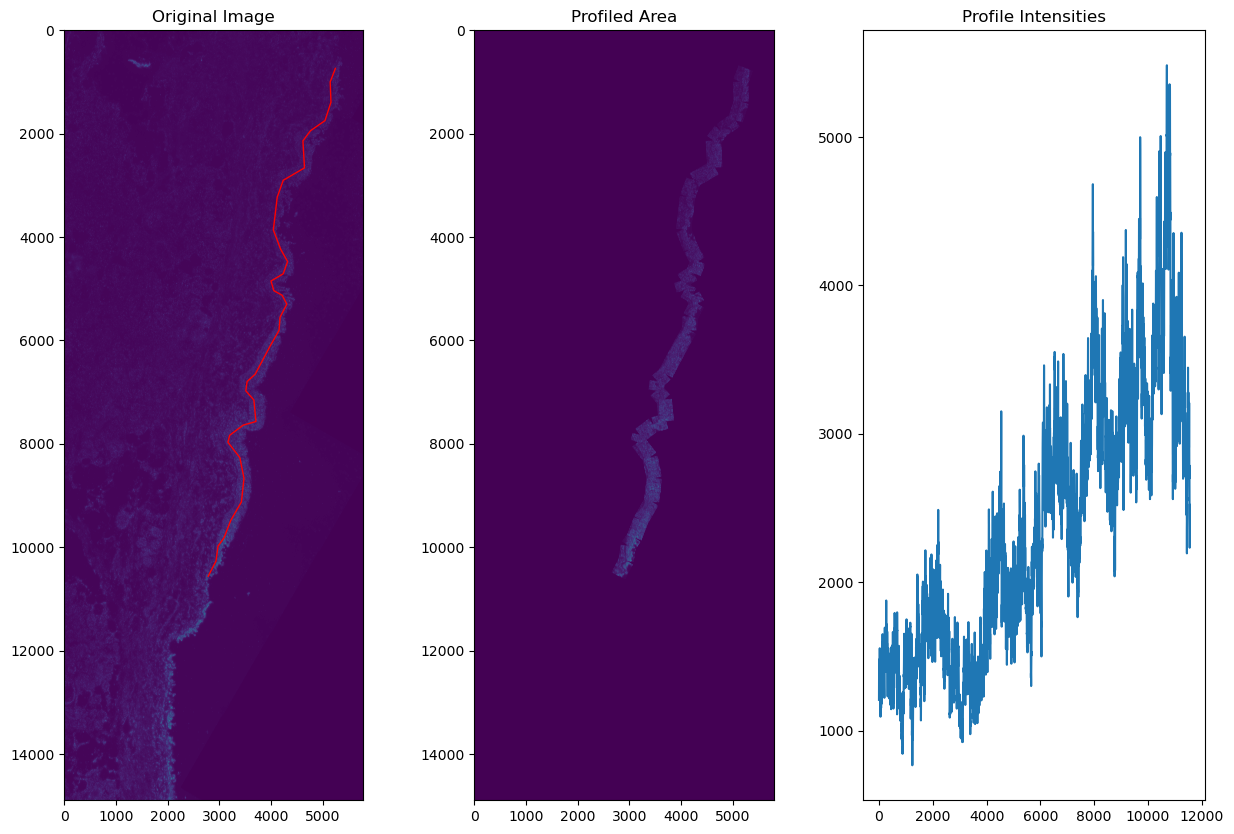

In [37]:
for width in [51, 101, 201, 301]:
    plot_profiled_area(fos_scrins, path_scrins, width=width)

Observations:
The intesities are actually quite robust over different widths. 101 and 201 are both good options (visually in the image, and robustness of the intensities). We will go with 101 as the masked image looks like it's more restricted to the actual epithelium.

In [14]:
WIDTH = 101

We have a little problem: the landmarks are only in the high res paths not necessarily in the normal paths. Let's check if the profile with the high res paths also work. 

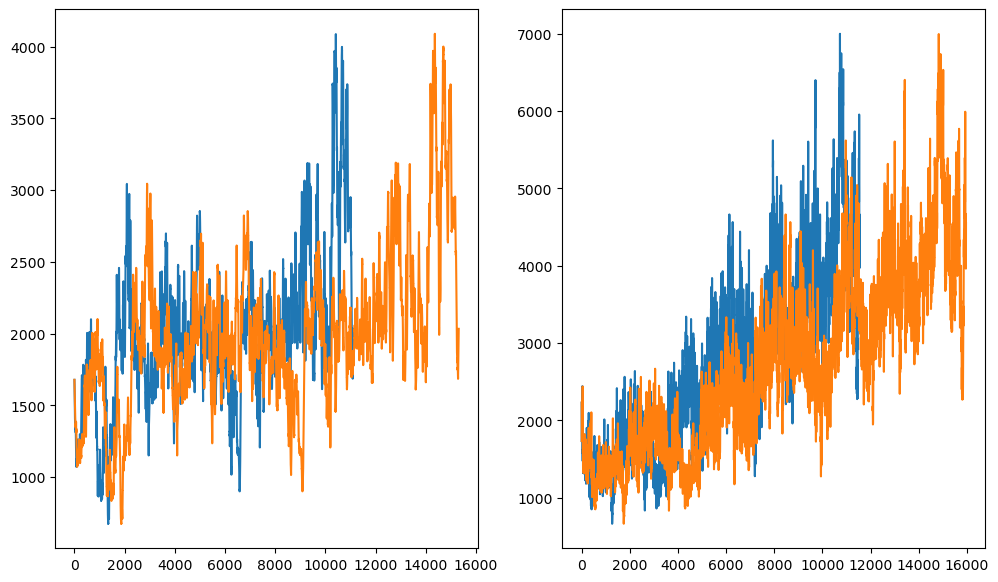

In [15]:
tmp1_ihc = np.concatenate(get_profile(fos_ihc, path_ihc, width=WIDTH))
tmp2_ihc = np.concatenate(get_profile(fos_ihc, path_ihc_hres, width=WIDTH))
tmp1_scrins = np.concatenate(get_profile(fos_scrins, path_scrins, width=WIDTH))
tmp2_scrins = np.concatenate(get_profile(fos_scrins, path_scrins_hres, width=WIDTH))

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].plot(tmp1_ihc)
ax[0].plot(tmp2_ihc)
ax[1].plot(tmp1_scrins)
ax[1].plot(tmp2_scrins)
plt.show()


Oberservations:
Yes, the profiles are very similar. Only the number of points in different path sections is different. This is not a problem since we'll account for that anyway in the following steps. Let's move on with the high res paths.

Update! Actually we have a possible duplication of values when converting the path into a higher resolution. It's reasonable to have two intensity values for the nodes the define the path as the angle of the line changes at node and therefore the intensity as well. However when we add multiple additional nodes this leads to a duplication that we need to remove. Take only the landmarks of the high res path additionally to the nodes for of the initial path.

In [16]:
# Add landmarks to the paths
filter1 = np.any(np.all(path_ihc_hres[:, np.newaxis] == path_ihc, axis=2), axis=1)
filter2 = np.any(np.all(path_ihc_hres[:, np.newaxis] == landmarks_ihc, axis=2), axis=1)
path_ihc = path_ihc_hres[filter1 | filter2]

filter1 = np.any(np.all(path_scrins_hres[:, np.newaxis] == path_scrins, axis=2), axis=1)
filter2 = np.any(np.all(path_scrins_hres[:, np.newaxis] == landmarks_scrins, axis=2), axis=1)
path_scrins = path_scrins_hres[filter1 | filter2]

## 4. Scale lengths of sections between landmarks to make the two slices comparable
- **Objective**: Determine and define landmarks within the profiles.
- **Output**: Landmarks within the profiles for IHC and SCRINSHOT slices.

In [17]:
import math

def get_profile_sections(image, path, landmarks, width=WIDTH, verbose=True):
    
    # Check that all landmarks occur in path
    assert np.all([np.any(np.all(landmark == path, axis=1)) for landmark in landmarks])
    
    section_profiles = []
    section_length = []
    #section_n_per_length = []
    for i in range(len(path) - 1):
        start, end = path[i], path[i+1]
        l = np.linalg.norm(end - start)
        profile = profile_line(image, start, end, linewidth=width)
        if verbose and (i < 15):
            print("nr of points: ", profile.shape[0], " - length: ", l)
        if verbose and (i == 15):
            print("...")
        
        # If start is in landmarks, create new section
        if np.any(np.all(start == landmarks, axis=1)):
            section_profiles.append([profile])
            section_length.append([l])
            #section_n_per_length.append([math.ceil(profile.shape[0]/l)])
        else:
            section_profiles[-1].append(profile)
            section_length[-1].append(l)
            #section_n_per_length[-1].append(math.ceil(profile.shape[0]/l))
            
    for i in range(len(section_profiles)):
        section_profiles[i] = np.concatenate(section_profiles[i])
        section_length[i] = np.sum(section_length[i])
            
    return section_profiles, section_length #, section_n_per_length
            
            
def interp1d(array: np.ndarray, new_len: int) -> np.ndarray:
    la = len(array)
    return np.interp(np.linspace(0, la - 1, num=new_len), np.arange(la), array)


In [18]:
section_profiles_ihc, section_length_ihc = get_profile_sections(fos_ihc, path_ihc, landmarks_ihc, width=WIDTH)
section_profiles_scrins, section_length_scrins = get_profile_sections(fos_scrins, path_scrins, landmarks_scrins, width=WIDTH, verbose=False)


nr of points:  738  - length:  736.759969622852
nr of points:  246  - length:  244.98296730071843
nr of points:  370  - length:  368.3799848114264
nr of points:  32  - length:  30.13100284140637
nr of points:  278  - length:  276.20085937955884
nr of points:  349  - length:  347.3854809332401
nr of points:  257  - length:  255.27155128171165
nr of points:  311  - length:  309.2433307593532
nr of points:  381  - length:  379.4412126523514
nr of points:  178  - length:  176.38377633346875
nr of points:  372  - length:  370.86654685507193
nr of points:  7  - length:  5.062460286149873
nr of points:  128  - length:  126.56150715375298
nr of points:  334  - length:  332.37743640164945
nr of points:  130  - length:  128.8006050374188
...


Okay --> profiles are already measured with a reasonable/comparable number of points per distance interval. 
We don't need to interpolate to the same number of points per distance interval. We just need to interpolate to a comparable number for the two slices.

In [19]:
for p_ihc, p_scrins in zip(section_profiles_ihc, section_profiles_scrins):
    print(p_ihc.shape, p_scrins.shape)
    

(1386,) (1240,)
(2133,) (2417,)
(3176,) (2412,)
(2370,) (2578,)
(2051,) (2915,)


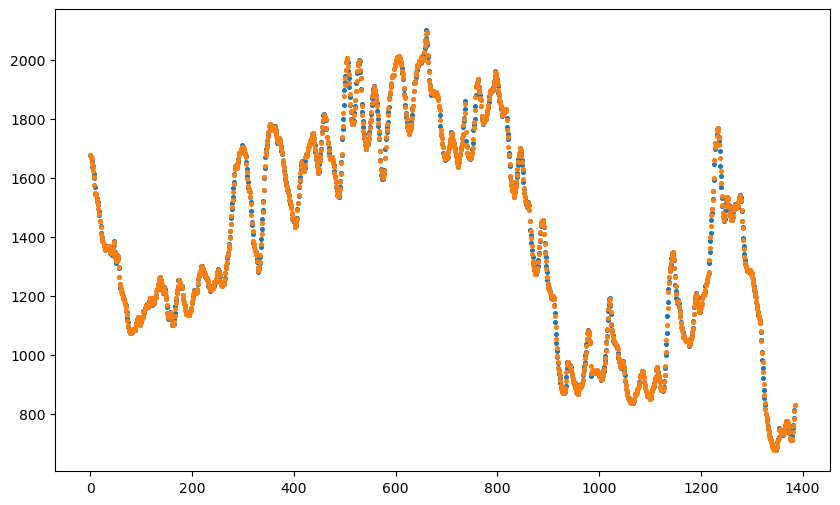

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(section_profiles_ihc[0])),section_profiles_ihc[0], s=7)
tmp = interp1d(section_profiles_ihc[0], section_profiles_scrins[0].shape[0])
plt.scatter(np.linspace(0, len(section_profiles_ihc[0])-1, num=len(tmp)), tmp, s=7)
plt.show()

In [23]:
# Interpolate the profiles to the same length (within each landmark section)
for i in range(len(section_profiles_ihc)):
    n_ihc = section_profiles_ihc[i].shape[0]
    n_scrins = section_profiles_scrins[i].shape[0]
    
    if n_ihc >= n_scrins:
        section_profiles_scrins[i] = interp1d(section_profiles_scrins[i], n_ihc)
    else:
        section_profiles_ihc[i] = interp1d(section_profiles_ihc[i], n_scrins)
        

In [24]:
# Check that nr of points for both slices are the same now
for p_ihc, p_scrins in zip(section_profiles_ihc, section_profiles_scrins):
    print(p_ihc.shape, p_scrins.shape)


(1386,) (1386,)
(2417,) (2417,)
(3176,) (3176,)
(2578,) (2578,)
(2915,) (2915,)


PearsonRResult(statistic=0.53883294391811, pvalue=0.0)


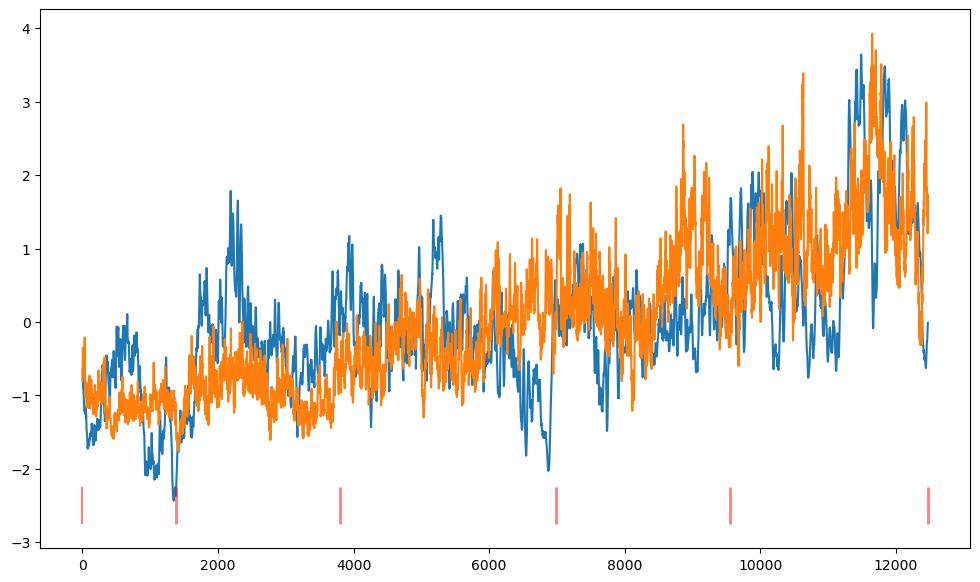

In [25]:
# calculate pearson correlation
from scipy.stats import pearsonr
ihc_signal = np.concatenate(section_profiles_ihc)
scrins_signal = np.concatenate(section_profiles_scrins)
print(pearsonr(ihc_signal, scrins_signal))

## min max scaling for each signal
#ihc_signal = (ihc_signal - np.min(ihc_signal)) / (np.max(ihc_signal) - np.min(ihc_signal))
#scrins_signal = (scrins_signal - np.min(scrins_signal)) / (np.max(scrins_signal) - np.min(scrins_signal))

# Scale signals to 0 mean and std 1
ihc_signal = (ihc_signal - np.mean(ihc_signal)) / np.std(ihc_signal)
scrins_signal = (scrins_signal - np.mean(scrins_signal)) / np.std(scrins_signal)


# plot
plt.figure(figsize=(12, 7))
plt.plot(ihc_signal)
plt.plot(scrins_signal)

# Get y limits from the plot
ylim = plt.gca().get_ylim()

vline_pos = 0
plt.vlines(vline_pos, ylim[0], ylim[0]+0.5, color='r', alpha=0.5)
for i in range(len(section_profiles_ihc)):
    vline_pos += section_profiles_ihc[i].shape[0]
    plt.vlines(vline_pos, ylim[0], ylim[0]+0.5, color='r', alpha=0.5, linewidth=2)
    #plt.vlines(np.sum(section_length_ihc[:i+1]), 0, 1, color='r', alpha=0.5)


# Final plots
- we need to crop the image to the interesting part
- plot the dapi image (and fos image) with the path and landmarks
- plot the masked fos image + adjust the contrast with napari
- plot both fos signals along the path with the landmarks as ticks

In [117]:
import colorsys


def get_r_colors(n):
    """
    Simulate the default colors of R's ggplot2 package.
    
    :param n: Number of colors to generate.
    :type n: int
    :return: A list of RGB color codes in hexadecimal format.
    :rtype: list
    """
    # Default saturation and luminance used by hue_pal()
    saturation = 1.0
    luminance = 0.65

    # Generate the colors
    colors = []
    for i in range(n):
        # Calculate hue
        hue = i / n

        # Convert from HSL to RGB
        r, g, b = colorsys.hls_to_rgb(hue, luminance, saturation)

        # Convert RGB to hexadecimal format
        hex_color = "#{:02x}{:02x}{:02x}".format(
            int(r * 255), int(g * 255), int(b * 255))

        # Append to list
        colors.append(hex_color)

    return colors

def plot_img_with_path_and_landmarks(
        img, path, landmarks, path_width=1, landmark_size=10, path_color='r', landmark_colors=['r','g'], save=False, dpi=150
    ):
    """
    """

    plt.imshow(img, cmap='gray')
    
    # Plot path
    plt.plot(path[:, 1], path[:, 0], color=path_color, linewidth=path_width)
    
    # Plot landmarks
    for i in range(landmarks.shape[0]):
        plt.scatter(landmarks[i, 1], landmarks[i, 0], s=landmark_size, color=landmark_colors[i])

    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
        
    if save:
        plt.savefig(save, dpi=dpi, bbox_inches='tight', pad_inches=0)
        plt.close()
    else:
        plt.show()
        
def get_img_with_adjusted_contrast(viewer_layer):
    """
    """
    return np.clip(viewer_layer.data, viewer_layer._contrast_limits[0], viewer_layer._contrast_limits[1])


In [ ]:
# Get landmark colors
landmark_colors = get_r_colors(len(landmarks_ihc))

In [46]:
# Define crop coordinates
XMIN, XMAX = 2000, 5500
YMIN, YMAX = 500, 11000

dapi_ihc_ = dapi_ihc[YMIN:YMAX, XMIN:XMAX]
dapi_scrins_ = dapi_scrins[YMIN:YMAX, XMIN:XMAX]
fos_ihc_ = fos_ihc[YMIN:YMAX, XMIN:XMAX]
fos_scrins_ = fos_scrins[YMIN:YMAX, XMIN:XMAX]
landmarks_ihc_ = landmarks_ihc - np.array([YMIN, XMIN])
landmarks_scrins_ = landmarks_scrins - np.array([YMIN, XMIN])
path_ihc_ = path_ihc - np.array([YMIN, XMIN])
path_scrins_ = path_scrins - np.array([YMIN, XMIN])


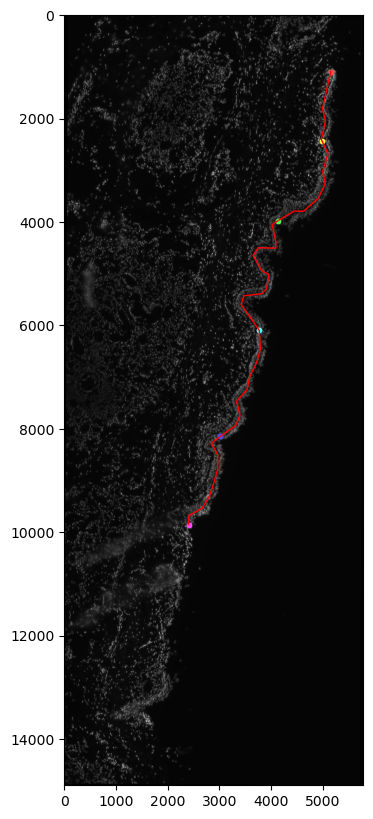

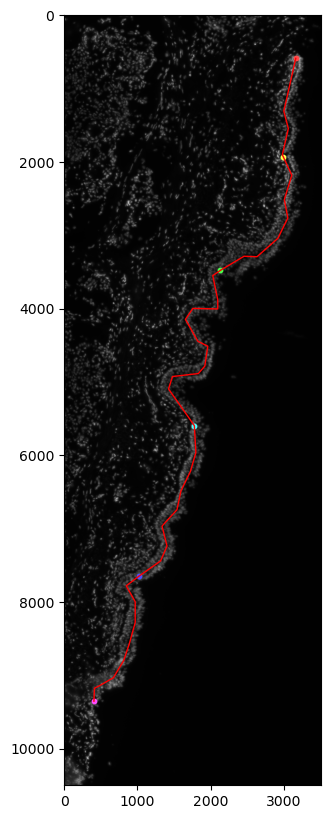

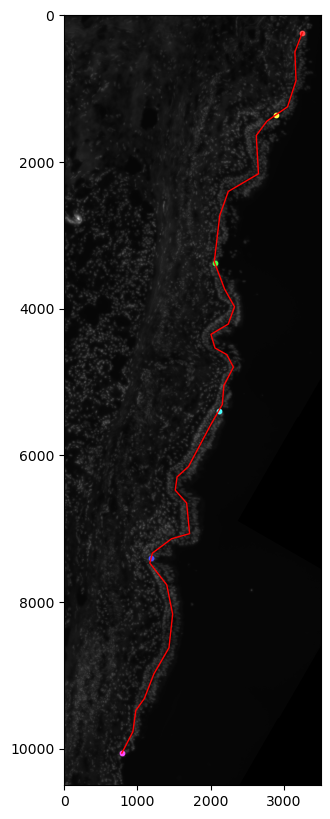

In [47]:
# Check plots to set XMIN, XMAX, YMIN, YMAX
plot_img_with_path_and_landmarks(dapi_ihc, path_ihc, landmarks_ihc, path_width=1,
                                 landmark_size=10, path_color='r', landmark_colors=get_r_colors(len(landmarks_ihc)))
plot_img_with_path_and_landmarks(dapi_ihc_, path_ihc_, landmarks_ihc_, path_width=1,
                                 landmark_size=10, path_color='r', landmark_colors=get_r_colors(len(landmarks_ihc_)))
plot_img_with_path_and_landmarks(dapi_scrins_, path_scrins_, landmarks_scrins_, path_width=1,
                                 landmark_size=10, path_color='r', landmark_colors=get_r_colors(len(landmarks_scrins_)))

In [58]:
# Get FOS signal
masked_fos_ihc_ = get_masked_profiled_area(fos_ihc_, path_ihc_, WIDTH)
masked_fos_scrins_ = get_masked_profiled_area(fos_scrins_, path_scrins_, WIDTH)

/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_19611/3695099020.py:28: RuntimeWarning: invalid value encountered in divide
  normal_vector = normal_vector / np.linalg.norm(normal_vector)


In [ ]:
import napari

In [59]:
# Adjust contrast of images in napari
viewer = napari.view_image(dapi_ihc_, name="DAPI IHC", contrast_limits=[0, np.max(dapi_ihc_)])
viewer.add_image(dapi_scrins_, name="DAPI SCRINSHOT", contrast_limits=[0, np.max(dapi_scrins_)])
viewer.add_image(masked_fos_ihc_, name="FOS IHC", contrast_limits=[0, np.max(masked_fos_ihc_)])
viewer.add_image(masked_fos_scrins_, name="FOS SCRINSHOT", contrast_limits=[0, np.max(masked_fos_scrins_)])

<Image layer 'FOS SCRINSHOT' at 0x7f8864a33e80>

In [60]:
# Retrieve images with adjusted contrast
dapi_ihc_adjusted = get_img_with_adjusted_contrast(viewer.layers["DAPI IHC"])
dapi_scrins_adjusted = get_img_with_adjusted_contrast(viewer.layers["DAPI SCRINSHOT"])
fos_ihc_adjusted = get_img_with_adjusted_contrast(viewer.layers["FOS IHC"])
fos_scrins_adjusted = get_img_with_adjusted_contrast(viewer.layers["FOS SCRINSHOT"])

In [120]:
# print contrasts
print("DAPI IHC contrast: ", viewer.layers["DAPI IHC"].contrast_limits)
print("DAPI SCRINSHOT contrast: ", viewer.layers["DAPI SCRINSHOT"].contrast_limits)
print("FOS IHC contrast: ", viewer.layers["FOS IHC"].contrast_limits)
print("FOS SCRINSHOT contrast: ", viewer.layers["FOS SCRINSHOT"].contrast_limits)

DAPI IHC contrast:  [0.0, 9645.496402877698]
DAPI SCRINSHOT contrast:  [1604.8920863309352, 5835.971223021583]
FOS IHC contrast:  [0, 6108]
FOS SCRINSHOT contrast:  [0.0, 7641.323741007194]


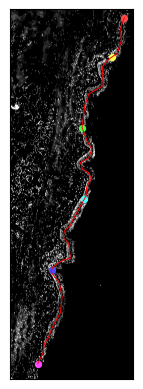

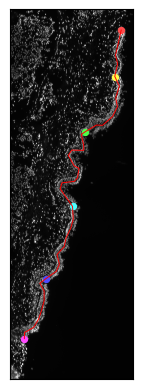

In [66]:
# Adjust landmark size and path width
LSIZE = 18
PWIDTH = 0.7
plot_img_with_path_and_landmarks(dapi_scrins_adjusted, path_scrins_, landmarks_scrins_, path_width=PWIDTH,
                                 landmark_size=LSIZE, path_color='r', landmark_colors=get_r_colors(len(landmarks_scrins_)))
plot_img_with_path_and_landmarks(dapi_ihc_adjusted, path_ihc_, landmarks_ihc_, path_width=PWIDTH,
                                    landmark_size=LSIZE, path_color='r', landmark_colors=get_r_colors(len(landmarks_ihc_)))


In [67]:
# Save images
Path('figures/trachea/FOS_validation').mkdir(parents=True, exist_ok=True)
plt.imsave('figures/trachea/FOS_validation/fos_ihc.png', fos_ihc_adjusted, cmap='gray', dpi=150)
plt.imsave('figures/trachea/FOS_validation/fos_scrins.png', fos_scrins_adjusted, cmap='gray', dpi=150)
plot_img_with_path_and_landmarks(dapi_scrins_adjusted, path_scrins_, landmarks_scrins_, path_width=PWIDTH,
                                 landmark_size=LSIZE, path_color='r', landmark_colors=get_r_colors(len(landmarks_scrins_)),
                                 save='figures/trachea/FOS_validation/dapi_scrins_landmarks.png', dpi=300)
plot_img_with_path_and_landmarks(dapi_ihc_adjusted, path_ihc_, landmarks_ihc_, path_width=PWIDTH,
                                 landmark_size=LSIZE, path_color='r', landmark_colors=get_r_colors(len(landmarks_ihc_)),
                                 save='figures/trachea/FOS_validation/dapi_ihc_landmarks.png', dpi=300)


##### Correlation plot

In [78]:
CROP_X_LENGTH = 1311.8 # um # NOTE: this measure is not extremely accurate --> should be updated (but not critical)
um_per_pixel = CROP_X_LENGTH/fos_ihc.shape[1]

In [79]:
um_per_pixel

0.22648480662983425

In [87]:
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 70
plt.rcParams['savefig.dpi'] = 150
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

PearsonRResult(statistic=0.53883294391811, pvalue=0.0)


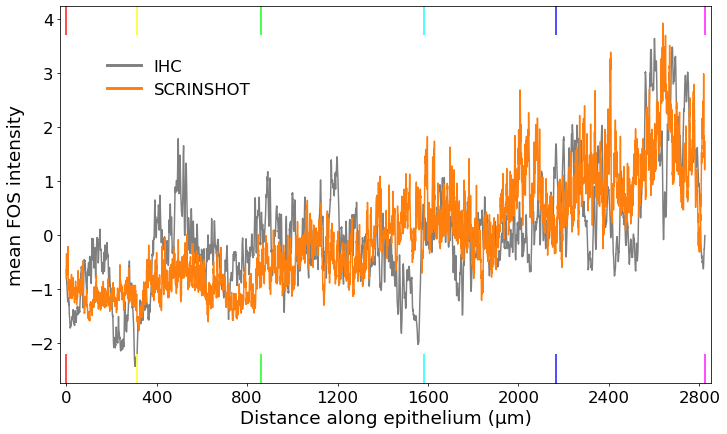

In [114]:
from matplotlib.lines import Line2D

x, y = np.array([[0.05, 0.1, 0.9], [0.05, 0.5, 0.9]])
line = Line2D(x, y, lw=5., color='r', alpha=0.4)

# calculate pearson correlation
from scipy.stats import pearsonr
ihc_signal = np.concatenate(section_profiles_ihc)
scrins_signal = np.concatenate(section_profiles_scrins)
print(pearsonr(ihc_signal, scrins_signal))

# Scale signals to 0 mean and std 1
ihc_signal = (ihc_signal - np.mean(ihc_signal)) / np.std(ihc_signal)
scrins_signal = (scrins_signal - np.mean(scrins_signal)) / np.std(scrins_signal)

# plot
plt.figure(figsize=(12, 7))
plt.plot(ihc_signal, label='IHC', color='#7f7f7f') 
plt.plot(scrins_signal, label='SCRINSHOT', color='#ff7f0e')

# Convert pixel ticks to µm, convert to integer
um_per_tick = 400
xticklabels = [int(v) for v in np.arange(0, len(ihc_signal), um_per_tick/um_per_pixel)*um_per_pixel]
plt.xticks(np.arange(0, len(ihc_signal), um_per_tick/um_per_pixel), xticklabels)

# labels
plt.xlabel('Distance along epithelium (µm)')
plt.ylabel('mean FOS intensity')

# Legend bottom right (plt. or ax.)
plt.legend(loc='upper left', bbox_to_anchor=(0.05, 0.9), frameon=False)

# Increase the thickness of the legend lines
leg = plt.gca().get_legend()
leg.legendHandles[0].set_linewidth(3)
leg.legendHandles[1].set_linewidth(3)

# Set x limits
plt.xlim(-120, len(ihc_signal)+120)

# Get y limits from the plot
ylim = plt.gca().get_ylim()

msize = 60
vline_pos = 0
plt.axvline(x=vline_pos, color=landmark_colors[0], linestyle='', marker='|', markersize=msize, mew=2)
for i in range(len(section_profiles_ihc)):
    vline_pos += section_profiles_ihc[i].shape[0]
    plt.axvline(x=vline_pos, color=landmark_colors[i+1], linestyle='', marker='|', markersize=msize, mew=2)

# Save figure
plt.savefig('figures/trachea/FOS_validation/fos_ihc_vs_scrinshot.png', bbox_inches='tight', dpi=150)
